In [459]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../code/')
import leakage

In [460]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [461]:
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

In [462]:
model.reactions.EX_glc__D_e.lower_bound = -10


In [521]:
def estimate_shadow_prices(model, intracellular_only = True, epsilon = 0.1):
    intracellular_only = True
    wt_growth_rate = model.slim_optimize()
    shadow_prices = {}
    for m in model.metabolites:
        if intracellular_only:
            if m.compartment != 'c':
                continue
        with model:
            try:
                r = model.reactions.get_by_id('DM_{0}'.format(m.id))
            except KeyError:
                r = model.add_boundary(m, type = 'demand')
            old_lb = r.lower_bound
            r.bounds = (old_lb + epsilon, 1000)
            shadow_prices[m.id] = (model.slim_optimize()-wt_growth_rate)/epsilon
        
    return shadow_prices

In [550]:
shadow_prices2 = estimate_shadow_prices(model, epsilon = 0.1)

In [551]:
shadow_prices2['ala__L_c']

-0.008157997084672353

In [552]:
solution.shadow_prices['ala__L_c']

-0.008157997084673851

2dmmq8_c 0.2513914867317373 -1.4593104732741906
2dmmql8_c 0.2508142254608499 -1.4572643002983892
athtp_c 0.0 -2.6633340431371435
colipa_c 0.7277794893911336 -2.7288698456520444
gagicolipa_c 0.000993940589525219 -2.5913962248468927
ggagicolipa_c 0.0004941679229288343 -2.6103075902218413
gggagicolipa_c 0.0 -2.629213350043607
gicolipa_c 0.0015142490054498858 -2.572464320756617
hhlipa_c -0.6201467613634597 -2.2750719307757903
hphhlipa_c 0.10087794064408473 -2.381732519235914
icolipa_c 0.0020559046966425742 -2.554310062278368
kphphhlipa_c 0.0 -2.482887980023985
lipa_cold_c 0.0 -2.1207194448060043
mql8_c -0.0017189015632333472 -1.7150112859585702
mqn8_c 0.0 -1.715419632974945
phhlipa_c -0.6269454490972091 -2.281799711516349
phphhlipa_c 0.09412919427639777 -2.388409362339395
q8_c 0.0 -1.6929041021735463
q8h2_c -0.001718901563233349 -1.694404298103717
uLa4fn_c -0.0015588533761565439 -1.48571639546346
uLa4n_c 0.0 -1.4843356943920605
uacmamu_c 1.3413395188930453 -0.36846142774190405
udpLa4fn_c 0

Text(0, 0.5, 'Gurobi predicted Shadow prices')

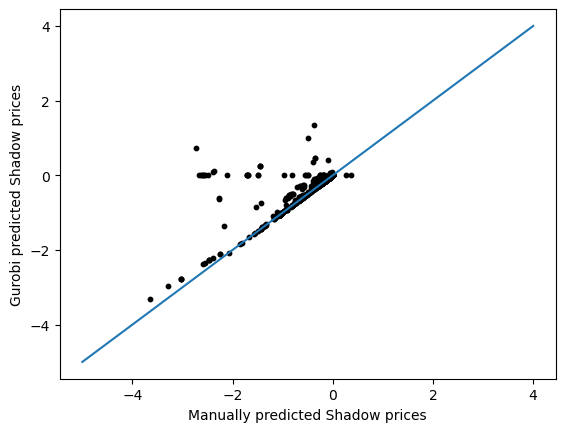

In [556]:
solution = model.optimize()
fig, ax = plt.subplots(1)
for m, sp2 in shadow_prices2.items():
    # print(m, sp2, solution.shadow_prices[m])
    sp1 = solution.shadow_prices[m]
    ax.scatter(sp2, sp1, c = 'k', s = 10)
    if abs(sp1 - sp2) > 1:
        # if np.abs((sp2-sp1)/min(abs(sp1), abs(sp2)))> 1:
        # ax.annotate(m[:-2], (sp2+1, sp1))
        print(m, sp1, sp2)
ax.plot(np.arange(-5, 5), np.arange(-5, 5))
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel('Manually predicted Shadow prices')
plt.ylabel('Gurobi predicted Shadow prices')

In [519]:
solution.shadow_prices

10fthf_c     -0.656662
12dgr120_c   -0.466064
12dgr140_c   -0.524186
12dgr141_c   -0.501553
12dgr160_c   -0.637621
                ...   
xtsn_p       -0.201325
xyl__D_p      0.004468
xylu__L_p    -0.008956
zn2_p        -0.000137
prot_pool    -5.929755
Name: shadow_prices, Length: 1806, dtype: float64

# FBA with leakage


## Define parameters

## Run standard FBA

In [464]:
solution = model.optimize()
print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6436981589523757

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195  

In [496]:
model.metabolites.q8_c.summary()
with model:
    m = model.metabolites.q8_c
    r = model.add_boundary(m, type = 'demand')
    r.lower_bound = 0.1
    solution = model.optimize()
    print(model.summary())
    print(solution.shadow_prices['q8_c'])
    

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.4744077487350215

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.002469         0   0.00%
      cl_e      EX_cl_e  0.002469         0   0.00%
 cobalt2_e EX_cobalt2_e 1.186E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0003364         0   0.00%
     fe2_e     EX_fe2_e  0.007619         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.0926         0   0.00%
     mg2_e     EX_mg2_e  0.004115         0   0.00%
     mn2_e     EX_mn2_e 0.0003278         0   0.00%
    mobd_e    EX_mobd_e  6.12E-05         0   0.00%
     nh4_e     EX_nh4_e     5.124         0   0.00%
     ni2_e     EX_ni2_e 0.0001532         0   0.00%
      o2_e      EX_o2_e     13.25         0   0.00%
      pi_e      EX_pi_e    0.4576         0   0.00%
     so4_e     EX_so4_e    0.1197         0   0.00%
     zn2_e     EX_zn2_e 0.0001618  

## set minimum growth rate to 0.95 of max

In [465]:
# model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = solution.objective_value*0.95
# print(model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.bounds)
# model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0

## Add leakage reactions

In [466]:
# Get index of intracellular metabolites
intracellular_metabolites = [m.id for m in model.metabolites if m.compartment =='c']


In [467]:
# Get stoichiometric matrix and flux array
S_matrix = cobra.util.create_stoichiometric_matrix(model, array_type='DataFrame')
v_array = np.array(solution.fluxes)

In [468]:
# First find 'turnover-metabolites'
non_zero_reactions = solution.fluxes.abs() > 1e-2

In [469]:
non_zero_reactions

DM_4crsol_c          False
DM_5drib_c           False
DM_aacald_c          False
DM_amob_c            False
DM_mththf_c          False
                     ...  
XYLtex_TG_forward    False
XYLtex_TG_reverse    False
Zn2tex_TG_forward    False
Zn2tex_TG_reverse    False
ER_pool_TG_           True
Name: fluxes, Length: 3178, dtype: bool

In [470]:
# Remove non-intracellular metabolites and zero-flux reactions
S_reduced = S_matrix.loc[intracellular_metabolites, non_zero_reactions]

In [471]:
# Remove metabolites that have all zero rows in the S_non_zero matrix
nonzero_mets = (S_reduced != 0).any(axis = 1)
nonzero_rxns2 = (S_reduced != 0).any(axis = 0)

In [472]:
S = S_reduced.loc[nonzero_mets, nonzero_rxns2]

# Remove prot pool

In [473]:
S = S.loc[S.index!='prot_pool',:]

# Remove ACP metabolites


In [474]:
S = S.loc[~S.index.str.contains('ACP'), :]

In [475]:
flux_carrying_mets = S.index

In [476]:
r.boundary

False

In [477]:
rex = ['4crsol_c','5drib_c','amob_c','mththf_c']
for r_id in rex:
    print(r_id, r_id in S.index)

4crsol_c False
5drib_c False
amob_c False
mththf_c False


In [478]:
# List already excreted metabolites
exchanged_mets = []
for r in model.boundary:
    flux = solution.fluxes[r.id]
    if flux != 0:
        exchanged_mets.append(list(r.metabolites.keys())[0].id)
        

In [479]:
exchanged_mets

['4crsol_c',
 '5drib_c',
 'amob_c',
 'mththf_c',
 'ac_e',
 'ca2_e',
 'cl_e',
 'co2_e',
 'cobalt2_e',
 'cu2_e',
 'fe2_e',
 'glc__D_e',
 'h_e',
 'h2o_e',
 'k_e',
 'meoh_e',
 'mg2_e',
 'mn2_e',
 'mobd_e',
 'nh4_e',
 'ni2_e',
 'o2_e',
 'pi_e',
 'so4_e',
 'zn2_e',
 'prot_pool']

# Implementation 2



In [485]:
with model as M2:
    # Predict leakage rate
    leakage_rate = {}
    leakage_slope = -1.1
    leakage_cost = {}
    leak_reactions = {}
    # new_metabolites = []
    for i, m_id in enumerate(flux_carrying_mets):
        if m_id in exchanged_mets:
            continue
        # print(i, m_id)
        m = M2.metabolites.get_by_id(m_id)
        # Check if demand reaction exist
        for r in m.reactions:
            if r.boundary:
                print(r)
        try:
            m_e = M2.metabolites.get_by_id(m_id.replace('_c','_e'))
        except KeyError:
            # m_e = cobra.Metabolite(m_id.replace('_c','_e'))
            m_e = m.copy()
            m_e.id = m_id.replace('_c','_e')
            m_e.compartment = 'e'
            M2.add_boundary(m_e, type='exchange')
        else:
            r_ex = model.reactions.get_by_id('EX_{0}'.format(m_e))
            r_ex.upper_bound = 1000

        sp = solution.shadow_prices[m_id]
        if sp > -1e-6:
            # print(m_id, sp)
            continue
        else:
            r = cobra.Reaction('LEAK_{0}'.format(m_id))
            r.add_metabolites({m:-1, m_e:1})
            r.bounds = (0, 1000)
            leak_reactions[m_id] = r
            leak_mets.append(m)
            leakage_rate[m_id] = np.abs(sp)**leakage_slope
            leakage_cost[m_id] = np.abs(sp)*leakage_rate[m_id]

    delta_growth = solution.objective_value*(1-0.95)
    scale = delta_growth/sum(leakage_cost.values())
    M2.add_reactions(leak_reactions.values())
    for m_id, r0 in leak_reactions.items():
        r = M2.reactions.get_by_id(r0.id)
        lr = leakage_rate[m_id]
        r.lower_bound = scale*lr
        # print(m_id, scale*lr, r)
    # print(r)
    # r.lower_bound = 1
    
    M2.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
    solution2 = M2.optimize()
    print(M2.summary())
    print(solution2.objective_value)
    
    

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.4521675022284977

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.002354         0   0.00%
      cl_e      EX_cl_e  0.002354         0   0.00%
 cobalt2_e EX_cobalt2_e  1.13E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0003206         0   0.00%
     fe2_e     EX_fe2_e    0.1867         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e   0.08826         0   0.00%
     mg2_e     EX_mg2_e  0.003923         0   0.00%
     mn2_e     EX_mn2_e 0.0003124         0   0.00%
    mobd_e    EX_mobd_e 5.936E-05         0   0.00%
     nh4_e     EX_nh4_e     5.155         0   0.00%
     ni2_e     EX_ni2_e 0.0001461         0   0.00%
      o2_e      EX_o2_e     13.73         0   0.00%
      pi_e      EX_pi_e     0.863         0   0.00%
     so4_e     EX_so4_e    0.1196         0   0.00%
     zn2_e     EX_zn2_e 0.0001542  

In [481]:
delta_growth = solution.objective_value*(1-0.95)
scale = delta_growth/sum(leakage_cost.values())

In [482]:
for r in model.metabolites.acser_e.reactions:
    print(r.id, r.bounds)

EX_acser_e (0.0, 0.0)
ACSERtex_TG_forward (0.0, 1000.0)
ACSERtex_TG_reverse (0.0, 1000.0)


In [283]:
model.add_reactions(leak_reactions.values())

Ignoring reaction 'LEAK_10fthf_c' since it already exists.
Ignoring reaction 'LEAK_13dpg_c' since it already exists.
Ignoring reaction 'LEAK_1ddecg3p_c' since it already exists.
Ignoring reaction 'LEAK_1hdec9eg3p_c' since it already exists.
Ignoring reaction 'LEAK_1hdecg3p_c' since it already exists.
Ignoring reaction 'LEAK_1pyr5c_c' since it already exists.
Ignoring reaction 'LEAK_23dhdp_c' since it already exists.
Ignoring reaction 'LEAK_23dhmb_c' since it already exists.
Ignoring reaction 'LEAK_23dhmp_c' since it already exists.
Ignoring reaction 'LEAK_25aics_c' since it already exists.
Ignoring reaction 'LEAK_26dap_LL_c' since it already exists.


In [284]:
model.reactions.LEAK_10fthf_c

Reaction identifier,LEAK_10fthf_c
Name,
Memory address,0x7fca41692ee0
Stoichiometry,10fthf_c --> 10fthf_e 10-Formyltetrahydrofolate --> 10-Formyltetrahydrofolate
GPR,
Lower bound,0.009657670567685996
Upper bound,1000


In [285]:
for m_id, r0 in leak_reactions.items():
    r = model.reactions.get_by_id(r0.id)
    lr = leakage_rate[m_id]
    r.lower_bound = scale*lr
    print(m_id, scale*lr, r)


10fthf_c 0.0028042847245541556 LEAK_10fthf_c: 10fthf_c --> 10fthf_e
13dpg_c 0.018598979556040653 LEAK_13dpg_c: 13dpg_c --> 13dpg_e
1ddecg3p_c 0.004614897371267048 LEAK_1ddecg3p_c: 1ddecg3p_c --> 1ddecg3p_e
1hdec9eg3p_c 0.004239739256961746 LEAK_1hdec9eg3p_c: 1hdec9eg3p_c --> 1hdec9eg3p_e
1hdecg3p_c 0.003948916413249949 LEAK_1hdecg3p_c: 1hdecg3p_c --> 1hdecg3p_e
1pyr5c_c 0.01392670868114295 LEAK_1pyr5c_c: 1pyr5c_c --> 1pyr5c_e
23dhdp_c 0.012088348467733117 LEAK_23dhdp_c: 23dhdp_c --> 23dhdp_e
23dhmb_c 0.008290662279444106 LEAK_23dhmb_c: 23dhmb_c --> 23dhmb_e
23dhmp_c 0.008078527419470256 LEAK_23dhmp_c: 23dhmp_c --> 23dhmp_e
25aics_c 0.005065327869626255 LEAK_25aics_c: 25aics_c --> 25aics_e
26dap_LL_c 0.010284338954929976 LEAK_26dap_LL_c: 26dap_LL_c --> 26dap_LL_e
26dap__M_c 0.010202007074011513 LEAK_26dap__M_c: 26dap__M_c --> 26dap__M_e
2ahbut_c 0.010709085327625814 LEAK_2ahbut_c: 2ahbut_c --> 2ahbut_e
2cpr5p_c 0.005473955970806087 LEAK_2cpr5p_c: 2cpr5p_c --> 2cpr5p_e
2dda7p_c 0.0138262

In [286]:
model.reactions.EX_10fthf_e.lower_bound = leakage_rate['10fthf_c']*scale

In [287]:
leakage_rate['10fthf_c']

1.2340391637257282

In [288]:
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1

In [289]:
model.optimize()

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x7fca59232f10>

In [271]:
model.reactions.LEAK_13dpg_c.bounds

(0, 1000)

# Implementation 1 - seems to not working when the number of leakage-reactions increases above 20 ish
## Now actually add these reactions

In [140]:
with model as M:
    scale = M.problem.Variable('leakage_scale')
    M.add_cons_vars([scale])
    
    leak_reactions = []
    leak_mets = []
    for i, m_id in enumerate(flux_carrying_mets):
        m = M.metabolites.get_by_id(m_id)
        sp = solution.shadow_prices[m_id]
        if sp > -1e-6:
            print(m_id, sp)
            continue
        else:
            r = cobra.Reaction('LEAK_{0}'.format(m_id))
            r.add_metabolites({m:-1})
            r.bounds = (0, 1000)
            leak_reactions.append(r)
            leak_mets.append(m)
        if i > 40:
            break
    M.add_reactions(leak_reactions)
    constraints = []
    for m, r in zip(leak_mets, leak_reactions):
        sp = solution.shadow_prices[m.id]
        if sp == 0:
            print(sp)
        leakage = 1e-4*np.abs(sp)**(-1)
        constraint = M.problem.Constraint(
            r.flux_expression - scale*leakage,
            lb=0,
            ub=100)
        constraints.append(constraint)
    M.add_cons_vars(constraints)
    obj = M.problem.Objective(M.solver.variables.leakage_scale, direction = 'max')
    M.objective = obj
    new_solution = M.optimize(objective_sense=None)

3haACP_c 0.08994442688854631
3hhexACP_c 0.049009775741353484
3hoctACP_c 0.005546869119215869


In [141]:
new_solution.fluxes.to_csv('new_fluxes.csv')

# Get shadow prices

## And add constraints

In [142]:
    #slope = model.problem.Variable('leakage_slope')

In [143]:
    new_solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M']

0.6115132510047568

In [144]:
print(model.summary())

Non-linear or non-reaction model objective. Falling back to minimal display.


Objective
nan Expression = nan

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003183         0   0.00%
      cl_e      EX_cl_e  0.003183         0   0.00%
 cobalt2_e EX_cobalt2_e 1.529E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004336         0   0.00%
     fe2_e     EX_fe2_e  0.009822         0   0.00%
  glc__D_e  EX_glc__D_e     9.904         6 100.00%
       k_e       EX_k_e    0.1194         0   0.00%
     mg2_e     EX_mg2_e  0.005305         0   0.00%
     mn2_e     EX_mn2_e 0.0004226         0   0.00%
    mobd_e    EX_mobd_e 7.889E-05         0   0.00%
     nh4_e     EX_nh4_e     6.605         0   0.00%
     ni2_e     EX_ni2_e 0.0001975         0   0.00%
      o2_e      EX_o2_e     12.92         0   0.00%
      pi_e      EX_pi_e    0.5899         0   0.00%
     so4_e     EX_so4_e    0.1542         0   0.00%
     zn2_e     EX_zn2_e 0.0002085         0   0.00%

Secretion
-------